# Abstract

There has been lots of researches on stock prediction from the past by using statistical methods. Now machine learning and deep learning techniques are being implemented and tested. Here I am going to test all three different approaches and see talk about their pros and cons.


<br><br>
First just by using stock closing price forecast --> Show that is will do good before covid and bad if external factors such as covid arise. Collect data(news, etc...) that will mitigate external factors to show importance of data collection.

# Data Extraction

## NYSE Stock data

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import yfinance as yf

In [2]:
def GetStockData(ticker_name, period, start_date, end_date):
    tickerData = yf.Ticker(ticker_name)
    df = tickerData.history(period=period, start=start_date, end=end_date)
    return df

full_nvda_df = GetStockData("NVDA", "1d", "2016-01-01", "2020-10-10")

In [3]:
nvda_df = full_nvda_df[["Close"]].copy()

## related news

# Data Cleansing

# EDA

In [56]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = nvda_df.index,
        y = nvda_df["Close"]
    )
)

fig.update_layout(
    title = "<b>Nvidia closing prices</b>",
    yaxis_title = "Dollars",
    xaxis_title = "date"
)

fig.show()

# Predictive models

## ARIMA

When you have time series data, before using ARIMA model to forecast you must check if time series data is stationary.

In [5]:
nvda_df = full_nvda_df[["Close"]].copy()

### ADF test

In [7]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

dftest = adfuller(nvda_df["Close"], autolag="AIC")


dfoutput = pd.Series(dftest[0:4], index=["Test Stats", "p-value", "# Lags", "# of obs"])
for key, value in dftest[4].items():
    dfoutput[f"Critical Value ({key})"] = value
    
print(dfoutput)

Test Stats                 1.812313
p-value                    0.998373
# Lags                    13.000000
# of obs                1189.000000
Critical Value (1%)       -3.435862
Critical Value (5%)       -2.863974
Critical Value (10%)      -2.568066
dtype: float64


In [8]:
nvda_df["1st_diff"] = nvda_df["Close"].diff()
nvda_df["2nd_diff"] = nvda_df["1st_diff"].diff()

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [10]:
from plotly.subplots import make_subplots

In [64]:
fig = make_subplots(rows=2, cols=1)

for idx, d in enumerate(["1st_diff", "2nd_diff"]):
    fig.add_trace(
        go.Scatter(
            name = d,
            x = nvda_df.index,
            y = nvda_df[d]
        ),
        row=idx+1,col=1
    )
fig.update_layout(
    title="Differnced plots"
)
    
fig.show()

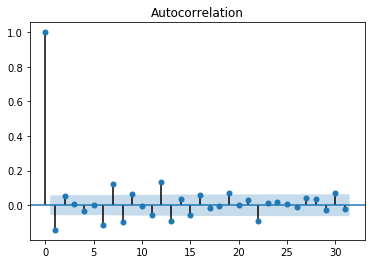

In [65]:
plot_acf(nvda_df["1st_diff"].dropna());

even with 1st order differencing, it reaches negative right away which implies that it may be over differenced. 

What to do when it gets over differenced even with 1storder differencing??
- Add MA terms

In [15]:
# Use 1st_diff value???????

dftest = adfuller(nvda_df["1st_diff"].dropna(), autolag="AIC")


dfoutput = pd.Series(dftest[0:4], index=["Test Stats", "p-value", "# Lags", "# of obs"])
for key, value in dftest[4].items():
    dfoutput[f"Critical Value ({key})"] = value
    
print(dfoutput)

Test Stats             -9.385815e+00
p-value                 6.764171e-16
# Lags                  1.100000e+01
# of obs                1.190000e+03
Critical Value (1%)    -3.435857e+00
Critical Value (5%)    -2.863972e+00
Critical Value (10%)   -2.568065e+00
dtype: float64


In [22]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(nvda_df["Close"], order=(1, 1, 0)) # (p, d, q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1202
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3938.228
Method:                       css-mle   S.D. of innovations              6.407
Date:                Sun, 11 Oct 2020   AIC                           7882.455
Time:                        01:16:15   BIC                           7897.730
Sample:                             1   HQIC                          7888.209
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4316      0.162      2.668      0.008       0.115       0.749
ar.L1.D.Close    -0.1427      0.029     -4.999      0.000      -0.199      -0.087
                                    Root

C:\Users\haneu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\haneu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Auto ARIMA forecast

In [19]:
import pmdarima as pm

In [20]:
model = pm.auto_arima(nvda_df.Close, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7883.452, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7905.190, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7882.455, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7884.530, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7908.510, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7883.037, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7884.845, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7887.523, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.985 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1203
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3938.228
Date:                Sun, 11 Oct 2020   AIC                           7882.455
Time:                        01:14:0

-----

C:\Users\haneu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\haneu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



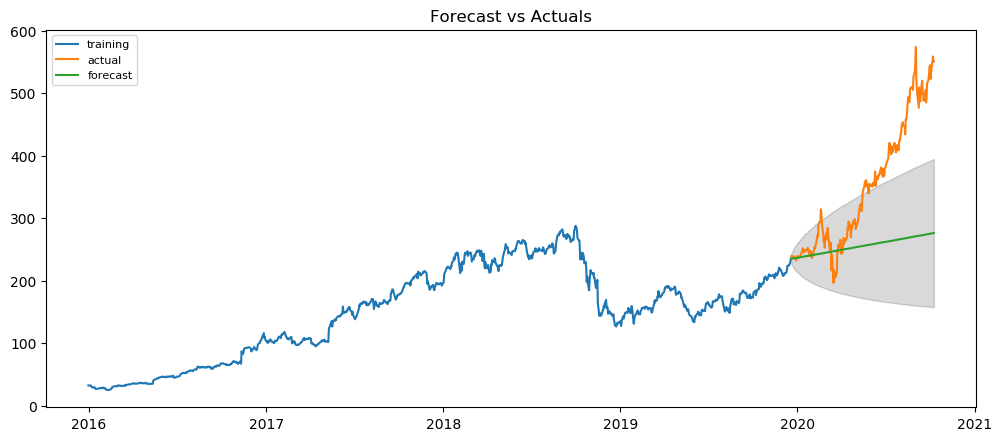

In [48]:
train = nvda_df.Close[:1000]
test  = nvda_df.Close[1000:]

model = ARIMA(train, order=(1, 1, 0))
fit_model = model.fit(disp=-1)

fc, se, conf = fit_model.forecast(203, alpha=0.05)  # 95% conf

fc_series    = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\haneu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\haneu\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



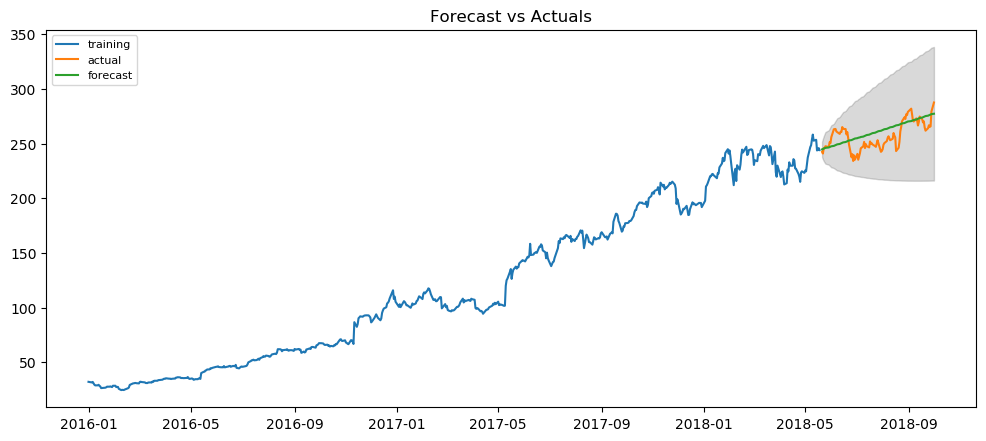

In [66]:
trunc_nvda_df = nvda_df[:"2018-10-01"].copy()
train = trunc_nvda_df.Close[:600]
test  = trunc_nvda_df.Close[600:]

model = ARIMA(train, order=(1, 1, 0))
fit_model = model.fit(disp=-1)

fc, se, conf = fit_model.forecast(93, alpha=0.05)  # 95% conf

fc_series    = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## RNN

## LSTM

# Sources

- https://www.youtube.com/watch?v=hOLSGMEEwlI&t=7s&ab_channel=ComputerScience
- https://www.kaggle.com/dgawlik/nyse/notebooks
- https://www.kaggle.com/c/two-sigma-financial-news
- https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70


<br>

Arima
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values.